# Natural Gas Consumtion forecast
This project involves developing a predictive model using a dataset spanning one year to forecast natural gas consumption for a 15-day period.

## Importing libs and data

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow.compute as pc
import seaborn as sns
import sys
from sklearn import linear_model, model_selection, preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Beállítások a trünkozás megakadályozására
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Beállítások a trünkozás megakadályozására
np.set_printoptions(threshold=sys.maxsize)

df_temp = pd.read_csv('outside_temperature.csv', delimiter=';', engine='pyarrow', dtype_backend='pyarrow', encoding='ISO-8859-1')
df_consumption = pd.read_csv('NatGasConsumption.csv', delimiter=';', engine='pyarrow', dtype_backend='pyarrow', encoding='ISO-8859-1')
forecast = pd.read_csv(r'15_day_hourly_weather_forecast.csv', encoding='ISO-8859-1')

print('temp memory usage', df_temp.memory_usage(deep=True).sum())
print('consumption memory usage', df_consumption.memory_usage(deep=True).sum())

def convert_to_datetime(df_to_convert):
    try:
        df_to_convert['Timestamp'] = pd.to_datetime(df_to_convert['Timestamp'])
        print("Column 'Timestamp' in {df_to_convert} converted to datetime.")
    except KeyError:
        print("Column 'Timestamp' not found.")
    return df_to_convert

# Set column names
df_temp.columns = ['Timestamp', 'OutsideTemp']
df_consumption.columns = ['Timestamp', 'Consumption']

# Convert , to .
df_temp['OutsideTemp'] = df_temp['OutsideTemp'].astype(str).str.replace(',', '.').astype('float[pyarrow]')
df_consumption['Consumption'] = df_consumption['Consumption'].astype(str).str.replace(',', '.').astype('float[pyarrow]')

# Convert date and time to datetime
convert_to_datetime(df_temp)
convert_to_datetime(df_consumption)

# Merge dataframes
df_merged = pd.merge(df_consumption, df_temp, on='Timestamp')
df_merged['OutsideTemp'] = round(df_merged['OutsideTemp'], 2).astype(float)
df_merged['Consumption'] = round(df_merged['Consumption'], 2).astype(float)

# Drop columns from downloaded 15 days weather data
forecast = forecast.drop(columns=['humidity', 'precipitation', 'conditions'])
forecast['datetime'] = pd.to_datetime(forecast['date'] + ' ' + forecast['datetime'])
forecast = forecast.drop(columns=['date'])

# Resample the forecast data to 12-hour intervals and take the mean
forecast_resampled = forecast.resample('12h', on='datetime').mean().reset_index()

# Filter the data to keep only 12:00:00 and 00:00:00 times
forecast_filtered = forecast_resampled[forecast_resampled['datetime'].dt.hour.isin([0, 12])]

print(forecast_filtered)


temp memory usage 31579
consumption memory usage 22481
Column 'Timestamp' in {df_to_convert} converted to datetime.
Column 'Timestamp' in {df_to_convert} converted to datetime.
              datetime  temperature
0  2025-02-08 00:00:00    -1.433333
1  2025-02-08 12:00:00     2.525000
2  2025-02-09 00:00:00    -1.450000
3  2025-02-09 12:00:00     2.325000
4  2025-02-10 00:00:00    -3.100000
5  2025-02-10 12:00:00     2.033333
6  2025-02-11 00:00:00    -2.375000
7  2025-02-11 12:00:00     1.575000
8  2025-02-12 00:00:00    -1.325000
9  2025-02-12 12:00:00     2.675000
10 2025-02-13 00:00:00    -0.491667
11 2025-02-13 12:00:00     3.200000
12 2025-02-14 00:00:00     1.200000
13 2025-02-14 12:00:00     3.008333
14 2025-02-15 00:00:00     0.100000
15 2025-02-15 12:00:00     2.458333
16 2025-02-16 00:00:00    -0.266667
17 2025-02-16 12:00:00     1.741667
18 2025-02-17 00:00:00    -0.841667
19 2025-02-17 12:00:00     1.300000
20 2025-02-18 00:00:00     0.275000
21 2025-02-18 12:00:00    -0.02

## Prepare and run model

              datetime  OutsideTemp  PredictedConsumption  \
0  2025-02-08 00:00:00    -1.433333           7759.965850   
1  2025-02-08 12:00:00     2.525000           4285.367983   
2  2025-02-09 00:00:00    -1.450000           7759.965850   
3  2025-02-09 12:00:00     2.325000           4780.494131   
4  2025-02-10 00:00:00    -3.100000           7352.901968   
5  2025-02-10 12:00:00     2.033333           5133.787161   
6  2025-02-11 00:00:00    -2.375000           5540.514043   
7  2025-02-11 12:00:00     1.575000           5370.808064   
8  2025-02-12 00:00:00    -1.325000           6559.653975   
9  2025-02-12 12:00:00     2.675000           5100.932019   
10 2025-02-13 00:00:00    -0.491667           5541.255972   
11 2025-02-13 12:00:00     3.200000           4309.854087   
12 2025-02-14 00:00:00     1.200000           5216.044296   
13 2025-02-14 12:00:00     3.008333           4552.275879   
14 2025-02-15 00:00:00     0.100000           6007.868052   
15 2025-02-15 12:00:00  

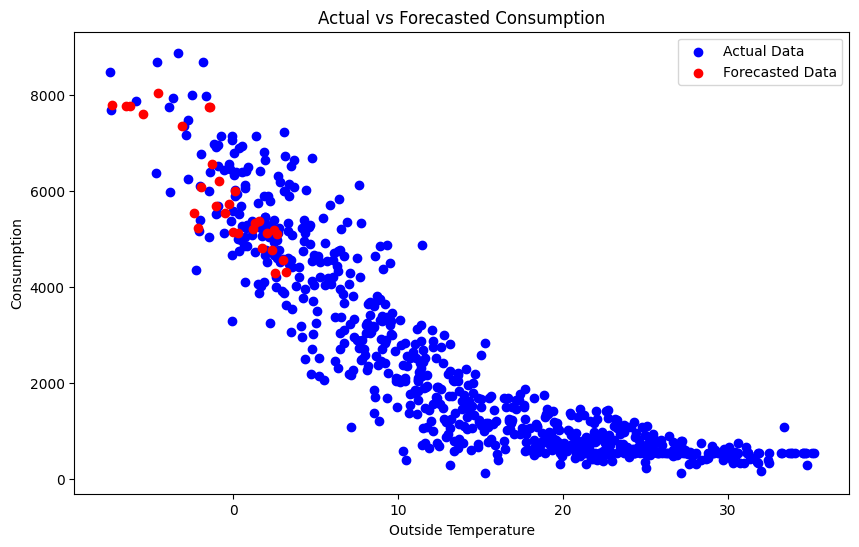

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Prepare the data for the linear regression model
X = df_merged[['OutsideTemp']]
y = df_merged['Consumption']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = linear_model.LinearRegression()

# Create and train the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Rename the column in forecast_filtered to match the model's input
forecast_filtered = forecast_filtered.rename(columns={'temperature': 'OutsideTemp'})

# Use the model to predict consumption for the temperatures in forecast_filtered
forecast_filtered['PredictedConsumption'] = model.predict(forecast_filtered[['OutsideTemp']])

print(forecast_filtered)

# Evaluate the performance (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
plt.figure(figsize=(10, 6))

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")
# Scatter plot for actual data
plt.scatter(df_merged['OutsideTemp'], df_merged['Consumption'], color='blue', label='Actual Data')

# Scatter plot for forecasted data
plt.scatter(forecast_filtered['OutsideTemp'], forecast_filtered['PredictedConsumption'], color='red', label='Forecasted Data')

plt.xlabel('Outside Temperature')
plt.ylabel('Consumption')
plt.title('Actual vs Forecasted Consumption')
plt.legend()
plt.savefig('random_forest.png', bbox_inches='tight', dpi=300)
plt.show()
from sklearn.metrics import mean_absolute_error, r2_score

## Same with XGBoost

Mean Squared Error (XGBoost): 634472.538298979
Mean Absolute Error (XGBoost): 558.2292580117985
R-squared (XGBoost): 0.8537658246711514


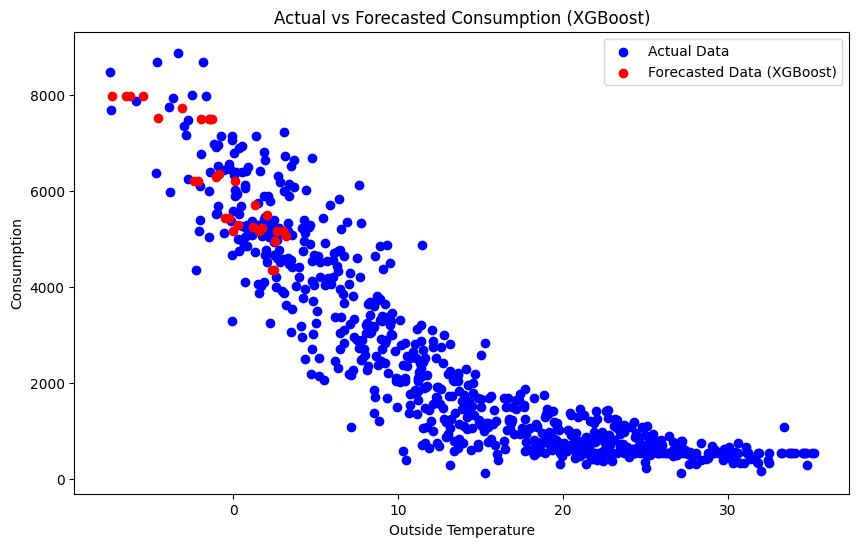

In [8]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Prepare the data for the XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.1,
    'seed': 42,
}

# Train the XGBoost model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(dtest)

# Use the model to predict consumption for the temperatures in forecast_filtered
dforecast = xgb.DMatrix(forecast_filtered[['OutsideTemp']])
forecast_filtered['PredictedConsumption_XGB'] = xgb_model.predict(dforecast)

'''
#########################################################
from scipy.stats import randint as sp_randint
param_grid = {
    'max_depth': [3, 5, 7],
    #'eta': [0.1, 0.5, 1],
    #'gamma': [0, 0.25, 1.0],
    #'subsample': [0.5, 0.75, 1],
    #'colsample_bytree': [0.5, 0.75, 1],
    'n_estimators': [None, 25, 50, 75, 100, 125, 150, 200]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score (MSE): {best_score}")
##########################################################
'''

#print(forecast_filtered)

# Evaluate the performance (Mean Squared Error)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"Mean Squared Error (XGBoost): {mse_xgb}")

# Calculate Mean Absolute Error
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"Mean Absolute Error (XGBoost): {mae_xgb}")

# Calculate R-squared
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"R-squared (XGBoost): {r2_xgb}")

plt.figure(figsize=(10, 6))

# Scatter plot for actual data
plt.scatter(df_merged['OutsideTemp'], df_merged['Consumption'], color='blue', label='Actual Data')

# Scatter plot for forecasted data using XGBoost
plt.scatter(forecast_filtered['OutsideTemp'], forecast_filtered['PredictedConsumption_XGB'], color='red', label='Forecasted Data (XGBoost)')

plt.xlabel('Outside Temperature')
plt.ylabel('Consumption')
plt.title('Actual vs Forecasted Consumption (XGBoost)')
plt.legend()
plt.savefig('XGBoost.png', bbox_inches='tight', dpi=300)
plt.show()

### Numerical valuses of the two model

In [9]:
forecast_filtered

,datetime,OutsideTemp,PredictedConsumption,PredictedConsumption_XGB
0,2025-02-08 00:00:00,-1.433333,7759.965850,7497.014648
1,2025-02-08 12:00:00,2.525000,4285.367983,4952.666016
2,2025-02-09 00:00:00,-1.450000,7759.965850,7497.014648
3,2025-02-09 12:00:00,2.325000,4780.494131,4351.807129
4,2025-02-10 00:00:00,-3.100000,7352.901968,7720.413574
5,2025-02-10 12:00:00,2.033333,5133.787161,5497.987793
6,2025-02-11 00:00:00,-2.375000,5540.514043,6213.896973
7,2025-02-11 12:00:00,1.575000,5370.808064,5159.969727
8,2025-02-12 00:00:00,-1.325000,6559.653975,7497.014648
9,2025-02-12 12:00:00,2.675000,5100.932019,5175.190430


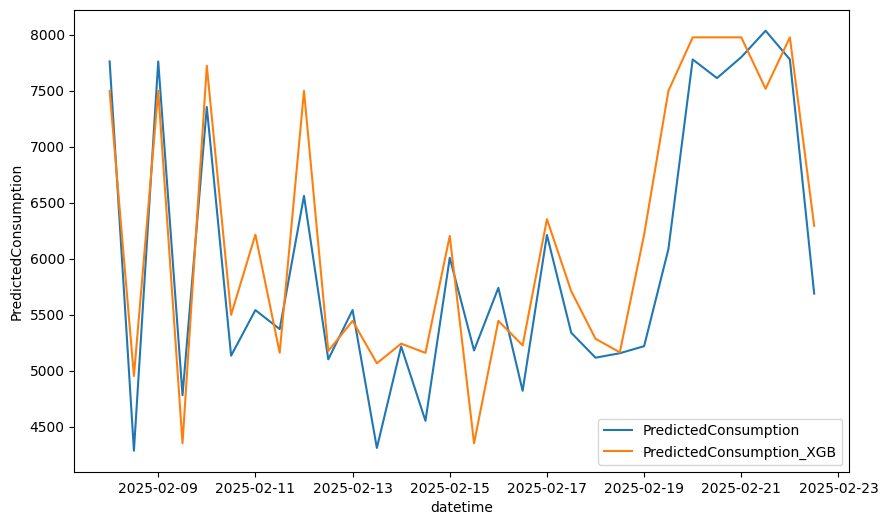

In [10]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='datetime', y='PredictedConsumption', data=forecast_filtered, label='PredictedConsumption')
sns.lineplot(x='datetime', y='PredictedConsumption_XGB', data=forecast_filtered, label='PredictedConsumption_XGB')
plt.savefig('forecast_graph.png', bbox_inches='tight', dpi=300)
plt.legend()
plt.show()

### Export to MS Excel

In [11]:
forecast_filtered.to_excel('forecast.xlsx')

In [78]:
# Creating and Fitting a Linear Regression Model
x = forecast_filtered['OutsideTemp'].values.reshape(-1 ,1) # Független változó
y = forecast_filtered['PredictedConsumption']  # Függő változó
x_x = forecast_filtered['OutsideTemp'].values.reshape(-1 ,1) # Független változó
y_x = forecast_filtered['PredictedConsumption_XGB']  # Függő változó

model = LinearRegression().fit(x, y)
model2 = LinearRegression().fit(x_x, y_x)

slope = model.coef_[0]  # Meredekség
intercept = model.intercept_  # Vágypont

slope2 = model2.coef_[0]  # Meredekség
intercept2 = model2.intercept_  # Vágypont

print(f"Regressziós egyenlet: y = {slope}x + {intercept}")
print(f"Regressziós egyenlet: y = {slope2}x + {intercept2}")

Regressziós egyenlet: y = -347.29575238280677x + 5702.661987611263
Regressziós egyenlet: y = -356.34046684051907x + 5922.734731236558
